## 1. Feature Extraction

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import IPython.display as ipd
from IPython.display import Audio

import multiprocessing as mp
import timeit
from tqdm import tqdm

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
speech = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
song = '/kaggle/input/ravdess-emotional-song-audio/audio_song_actors_01-24/'

In [3]:
speech_directory_list = os.listdir(speech)

speech_file_emotion = []
speech_file_path = []
for i in speech_directory_list:
    actor = os.listdir(speech + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        speech_file_emotion.append(int(part[2]))
        speech_file_path.append(speech + i + '/' + f)

In [4]:
song_directory_list = os.listdir(song)

song_file_emotion = []
song_file_path = []
for i in song_directory_list:
    actor = os.listdir(song + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        song_file_emotion.append(int(part[2]))
        song_file_path.append(song + i + '/' + f)

In [5]:
emotion_df = pd.DataFrame(speech_file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(speech_file_path, columns=['Path'])
speech_df = pd.concat([emotion_df, path_df], axis=1)
speech_df['Emotions'] = speech_df['Emotions'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
print(speech_df.head())
print("______________________________________________")
print(speech_df.tail())
print("_______________________________________________")
print(speech_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

<Axes: xlabel='Emotions'>

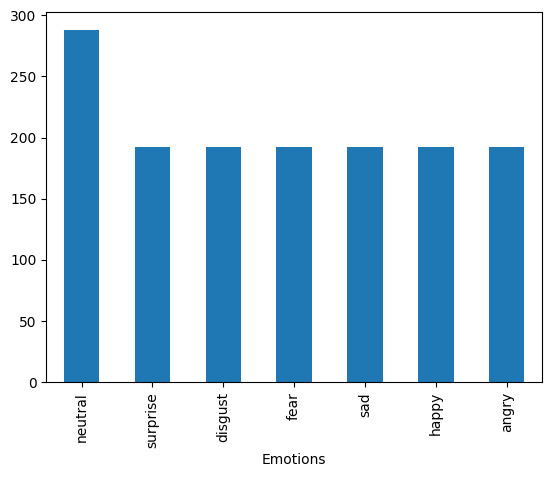

In [6]:
speech_df.Emotions.value_counts().plot(kind='bar')

In [7]:
emotion_df = pd.DataFrame(song_file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(song_file_path, columns=['Path'])
song_df = pd.concat([emotion_df, path_df], axis=1)
song_df['Emotions'] = song_df['Emotions'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
print(song_df.head())
print("______________________________________________")
print(song_df.tail())
print("_______________________________________________")
print(song_df.Emotions.value_counts())

  Emotions                                               Path
0    angry  /kaggle/input/ravdess-emotional-song-audio/aud...
1     fear  /kaggle/input/ravdess-emotional-song-audio/aud...
2    happy  /kaggle/input/ravdess-emotional-song-audio/aud...
3    happy  /kaggle/input/ravdess-emotional-song-audio/aud...
4      sad  /kaggle/input/ravdess-emotional-song-audio/aud...
______________________________________________
     Emotions                                               Path
1007  neutral  /kaggle/input/ravdess-emotional-song-audio/aud...
1008     fear  /kaggle/input/ravdess-emotional-song-audio/aud...
1009  neutral  /kaggle/input/ravdess-emotional-song-audio/aud...
1010  neutral  /kaggle/input/ravdess-emotional-song-audio/aud...
1011    angry  /kaggle/input/ravdess-emotional-song-audio/aud...
_______________________________________________
Emotions
neutral    276
angry      184
fear       184
happy      184
sad        184
Name: count, dtype: int64


<Axes: xlabel='Emotions'>

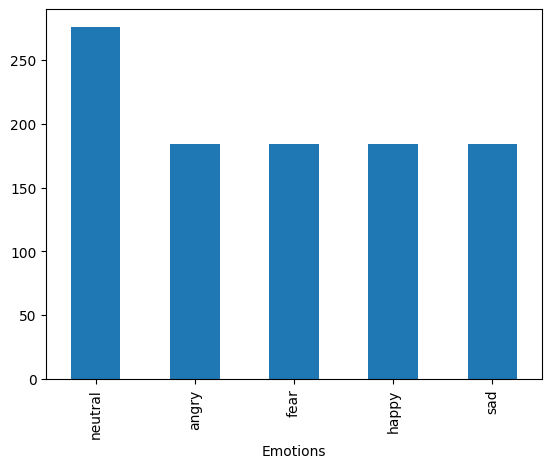

In [8]:
song_df.Emotions.value_counts().plot(kind='bar')

In [9]:
speech1,sr_sp = librosa.load(speech_file_path[0])
song1,sr_so = librosa.load(song_file_path[0])
print(sr_sp, sr_so)

22050 22050


In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [12]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr) # Returns 1D array

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse) # Returns 1D array

def mfcc(data, sr, frame_length=2048, hop_length=512):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return mfcc_result.T # Returns 2D array (time x n_mfcc)

def extract_spectrogram_features(data, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T # Returns 2D array (time x n_mels)

def extract_chroma_features(data, sr, frame_length=2048, hop_length=512):
    chromagram = librosa.feature.chroma_stft(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return chromagram.T # Returns 2D array (time x n_chroma)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512, dataset_type='speech'):
    zcr_features = zcr(data,frame_length,hop_length)
    rmse_features = rmse(data,frame_length,hop_length)
    mfcc_features = mfcc(data,sr,frame_length,hop_length)

    if dataset_type == 'speech':
        additional_features = extract_spectrogram_features(data, sr)
    elif dataset_type == 'song':
        additional_features = extract_chroma_features(data, sr, frame_length, hop_length)
    else:
        raise ValueError("dataset_type must be 'speech' or 'song'")

    return zcr_features, rmse_features, mfcc_features, additional_features

def get_features(path, dataset_type='speech', duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)

    # Extract features from original audio
    zcr_orig, rmse_orig, mfcc_orig, additional_orig = extract_features(data, sr, dataset_type=dataset_type)

    # Apply augmentation and extract features
    noised_audio = noise(data)
    zcr_noise, rmse_noise, mfcc_noise, additional_noise = extract_features(noised_audio, sr, dataset_type=dataset_type)

    # Use random rate for stretching
    stretch_rate = np.random.uniform(low=0.5, high=1.5)
    stretched_audio = stretch(data, rate=stretch_rate)
    zcr_stretch, rmse_stretch, mfcc_stretch, additional_stretch = extract_features(stretched_audio, sr, dataset_type=dataset_type)

    shifted_audio = shift(data)
    zcr_shift, rmse_shift, mfcc_shift, additional_shift = extract_features(shifted_audio, sr, dataset_type=dataset_type)

    pitched_audio = pitch(data, sr)
    zcr_pitch, rmse_pitch, mfcc_pitch, additional_pitch = extract_features(pitched_audio, sr, dataset_type=dataset_type)

    # Return a list of tuples, where each tuple contains the 1D and 2D features for one audio sample
    return [
        (zcr_orig, rmse_orig, mfcc_orig, additional_orig),
        (zcr_noise, rmse_noise, mfcc_noise, additional_noise),
        (zcr_stretch, rmse_stretch, mfcc_stretch, additional_stretch),
        (zcr_shift, rmse_shift, mfcc_shift, additional_shift),
        (zcr_pitch, rmse_pitch, mfcc_pitch, additional_pitch)
    ]

In [13]:
def process_audio_file(file_path, label):
    if 'speech' in file_path:
        dataset_type = 'speech'
    elif 'song' in file_path:
        dataset_type = 'song'
    else:
        raise ValueError("file_path must contain either 'speech' or 'song'")

    features = get_features(file_path, dataset_type=dataset_type)
    return features, label

In [14]:
speech_data = []
for index, row in speech_df.iterrows():
    speech_data.append((row['Path'], row['Emotions']))

song_data = []
for index, row in song_df.iterrows():
    song_data.append((row['Path'], row['Emotions']))

print(f"Number of speech data entries: {len(speech_data)}")
print(f"Number of song data entries: {len(song_data)}")
print("First 5 speech data entries:")
print(speech_data[:5])
print("First 5 song data entries:")
print(song_data[:5])

Number of speech data entries: 1440
Number of song data entries: 1012
First 5 speech data entries:
[('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav', 'surprise'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav', 'neutral'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav', 'disgust'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-01-01-02-02.wav', 'disgust'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-01-02.wav', 'neutral')]
First 5 song data entries:
[('/kaggle/input/ravdess-emotional-song-audio/audio_song_actors_01-24/Actor_02/03-02-05-02-01-01-02.wav', 'angry'), ('/kaggle/input/ravdess-emotional-song-audio/audio_song_actors_01-24/Actor_02/03-02-06-01-02-02-02.wav', 'fear'), ('/kaggle/input/ravdess-emotional-son

In [15]:
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        speech_results = list(tqdm(pool.starmap(process_audio_file, speech_data), total=len(speech_data), desc="Processing speech data"))
        song_results = list(tqdm(pool.starmap(process_audio_file, song_data), total=len(song_data), desc="Processing song data"))

print(f"\nNumber of speech results: {len(speech_results)}")
print(f"Number of song results: {len(song_results)}")

Processing song data: 100%|██████████| 1012/1012 [00:00<00:00, 2032871.48it/s]


Number of speech results: 1440
Number of song results: 1012


In [24]:
def pad_or_truncate(arr, max_len):
    """Pads or truncates a 2D array to a specified length."""
    if arr.shape[0] > max_len:
        return arr[:max_len, :]
    elif arr.shape[0] < max_len:
        padding = np.zeros((max_len - arr.shape[0], arr.shape[1]))
        return np.vstack((arr, padding))
    return arr

speech_zcr_stats = []
speech_rmse_stats = []
speech_mfcc_2d_padded = []
speech_spectrogram_2d_padded = []
speech_labels = []

song_zcr_stats = []
song_rmse_stats = []
song_mfcc_2d_padded = []
song_chroma_2d_padded = []
song_labels = []

# Determine the maximum length for 2D features
max_mfcc_len_speech = 0
max_spectrogram_len_speech = 0
max_mfcc_len_song = 0
max_chroma_len_song = 0

for features, label in speech_results:
    for zcr, rmse, mfcc, spectrogram in features:
        max_mfcc_len_speech = max(max_mfcc_len_speech, mfcc.shape[0])
        max_spectrogram_len_speech = max(max_spectrogram_len_speech, spectrogram.shape[0])

for features, label in song_results:
    for zcr, rmse, mfcc, chroma in features:
        max_mfcc_len_song = max(max_mfcc_len_song, mfcc.shape[0])
        max_chroma_len_song = max(max_chroma_len_song, chroma.shape[0])

# Save max lengths to files
with open('/kaggle/working/max_mfcc_len_speech.txt', 'w') as f:
    f.write(str(max_mfcc_len_speech))
with open('/kaggle/working/max_spectrogram_len_speech.txt', 'w') as f:
    f.write(str(max_spectrogram_len_speech))
with open('/kaggle/working/max_mfcc_len_song.txt', 'w') as f:
    f.write(str(max_mfcc_len_song))
with open('/kaggle/working/max_chroma_len_song.txt', 'w') as f:
    f.write(str(max_chroma_len_song))

# Pad or truncate 2D features and collect all features and labels
for features, label in speech_results:
    for zcr, rmse, mfcc, spectrogram in features:
        speech_zcr_stats.append([np.mean(zcr), np.std(zcr)])
        speech_rmse_stats.append([np.mean(rmse), np.std(rmse)])
        speech_mfcc_2d_padded.append(pad_or_truncate(mfcc, max_mfcc_len_speech))
        speech_spectrogram_2d_padded.append(pad_or_truncate(spectrogram, max_spectrogram_len_speech))
        speech_labels.append(label)


for features, label in song_results:
    for zcr, rmse, mfcc, chroma in features:
        song_zcr_stats.append([np.mean(zcr), np.std(zcr)])
        song_rmse_stats.append([np.mean(rmse), np.std(rmse)])
        song_mfcc_2d_padded.append(pad_or_truncate(mfcc, max_mfcc_len_song))
        song_chroma_2d_padded.append(pad_or_truncate(chroma, max_chroma_len_song))
        song_labels.append(label)

speech_zcr_stats = np.array(speech_zcr_stats)
speech_rmse_stats = np.array(speech_rmse_stats)
speech_mfcc_2d_padded = np.array(speech_mfcc_2d_padded)
speech_spectrogram_2d_padded = np.array(speech_spectrogram_2d_padded)
speech_labels = np.array(speech_labels)

song_zcr_stats = np.array(song_zcr_stats)
song_rmse_stats = np.array(song_rmse_stats)
song_mfcc_2d_padded = np.array(song_mfcc_2d_padded)
song_chroma_2d_padded = np.array(song_chroma_2d_padded)
song_labels = np.array(song_labels)

print("Speech Data Shapes:")
print("ZCR Stats (mean, std):", speech_zcr_stats.shape)
print("RMSE Stats (mean, std):", speech_rmse_stats.shape)
print("MFCC (Padded 2D):", speech_mfcc_2d_padded.shape)
print("Spectrogram (Padded 2D):", speech_spectrogram_2d_padded.shape)
print("Labels:", speech_labels.shape)

print("\nSong Data Shapes:")
print("ZCR Stats (mean, std):", song_zcr_stats.shape)
print("RMSE Stats (mean, std):", song_rmse_stats.shape)
print("MFCC (Padded 2D):", song_mfcc_2d_padded.shape)
print("Chroma (Padded 2D):", song_chroma_2d_padded.shape)
print("Labels:", song_labels.shape)

Speech Data Shapes:
ZCR Stats (mean, std): (7200, 2)
RMSE Stats (mean, std): (7200, 2)
MFCC (Padded 2D): (7200, 215, 20)
Spectrogram (Padded 2D): (7200, 215, 128)
Labels: (7200,)

Song Data Shapes:
ZCR Stats (mean, std): (5060, 2)
RMSE Stats (mean, std): (5060, 2)
MFCC (Padded 2D): (5060, 216, 20)
Chroma (Padded 2D): (5060, 216, 12)
Labels: (5060,)


In [83]:
# import numpy as np
# speech_zcr_stats = np.load("/kaggle/working/feats/speech/speech_zcr_stats.npy")
# speech_rmse_stats = np.load("/kaggle/working/feats/speech/speech_rmse_stats.npy")
# speech_mfcc_2d_padded = np.load("/kaggle/working/feats/speech/speech_mfcc_2d_padded.npy")
# speech_spectrogram_2d_padded = np.load("/kaggle/working/feats/speech/speech_spectrogram_2d_padded.npy")
# speech_labels = np.load("/kaggle/working/feats/speech/speech_labels.npy")

# song_zcr_stats = np.load("/kaggle/working/feats/song/song_zcr_stats.npy")
# song_rmse_stats = np.load("/kaggle/working/feats/song/song_rmse_stats.npy")
# song_mfcc_2d_padded = np.load("/kaggle/working/feats/song/song_mfcc_2d_padded.npy")
# song_chroma_2d_padded = np.load("/kaggle/working/feats/song/song_chroma_2d_padded.npy")
# song_labels = np.load("/kaggle/working/feats/song/song_labels.npy")

# print("Speech Data Shapes:")
# print("ZCR Stats (mean, std):", speech_zcr_stats.shape)
# print("RMSE Stats (mean, std):", speech_rmse_stats.shape)
# print("MFCC (Padded 2D):", speech_mfcc_2d_padded.shape)
# print("Spectrogram (Padded 2D):", speech_spectrogram_2d_padded.shape)
# print("Labels:", speech_labels.shape)

# print("\nSong Data Shapes:")
# print("ZCR Stats (mean, std):", song_zcr_stats.shape)
# print("RMSE Stats (mean, std):", song_rmse_stats.shape)
# print("MFCC (Padded 2D):", song_mfcc_2d_padded.shape)
# print("Chroma (Padded 2D):", song_chroma_2d_padded.shape)
# print("Labels:", song_labels.shape)

In [4]:
with open('/kaggle/working/max_len/max_chroma_len_song.txt', 'r') as f:
    print(f"max_chroma_len_song = {f.read()}")
with open('/kaggle/working/max_len/max_mfcc_len_song.txt', 'r') as f:
    print(f"max_mfcc_len_song = {f.read()}")
with open('/kaggle/working/max_len/max_mfcc_len_speech.txt', 'r') as f:
    print(f"max_mfcc_len_speech = {f.read()}")
with open('/kaggle/working/max_len/max_spectrogram_len_speech.txt', 'r') as f:
    print(f"max_spectrogram_len_speech = {f.read()}")

max_chroma_len_song = 216
max_mfcc_len_song = 216
max_mfcc_len_speech = 215
max_spectrogram_len_speech = 215


In [26]:
# Define file paths for saving
speech_zcr_path = 'speech_zcr_stats.npy'
speech_rmse_path = 'speech_rmse_stats.npy'
speech_mfcc_path = 'speech_mfcc_2d_padded.npy'
speech_spectrogram_path = 'speech_spectrogram_2d_padded.npy'
speech_labels_path = 'speech_labels.npy'

song_zcr_path = 'song_zcr_stats.npy'
song_rmse_path = 'song_rmse_stats.npy'
song_mfcc_path = 'song_mfcc_2d_padded.npy'
song_chroma_path = 'song_chroma_2d_padded.npy'
song_labels_path = 'song_labels.npy'

# Save speech data
np.save(speech_zcr_path, speech_zcr_stats)
np.save(speech_rmse_path, speech_rmse_stats)
np.save(speech_mfcc_path, speech_mfcc_2d_padded)
np.save(speech_spectrogram_path, speech_spectrogram_2d_padded)
np.save(speech_labels_path, speech_labels)

# Save song data
np.save(song_zcr_path, song_zcr_stats)
np.save(song_rmse_path, song_rmse_stats)
np.save(song_mfcc_path, song_mfcc_2d_padded)
np.save(song_chroma_path, song_chroma_2d_padded)
np.save(song_labels_path, song_labels)

print("Speech and song features and labels saved successfully.")

Speech and song features and labels saved successfully.


## 2. Model Training

### 2.1 Speech Emotion Recogniser

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt

2025-10-17 20:13:51.804621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760732031.994702      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760732032.048653      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
speech_zcr_stats = np.load("/kaggle/working/feats/speech/speech_zcr_stats.npy")
speech_rmse_stats = np.load("/kaggle/working/feats/speech/speech_rmse_stats.npy")
speech_mfcc_2d_padded = np.load("/kaggle/working/feats/speech/speech_mfcc_2d_padded.npy")
speech_spectrogram_2d_padded = np.load("/kaggle/working/feats/speech/speech_spectrogram_2d_padded.npy")
speech_labels = np.load("/kaggle/working/feats/speech/speech_labels.npy")

print("Shape of zcr_stats:", speech_zcr_stats.shape)
print("Shape of rmse_stats:", speech_rmse_stats.shape)
print("Shape of mfcc_2d_padded:", speech_mfcc_2d_padded.shape)
print("Shape of spectrogram_2d_padded:", speech_spectrogram_2d_padded.shape)
print("Shape of labels:", speech_labels.shape)

Shape of zcr_stats: (7200, 2)
Shape of rmse_stats: (7200, 2)
Shape of mfcc_2d_padded: (7200, 215, 20)
Shape of spectrogram_2d_padded: (7200, 215, 128)
Shape of labels: (7200,)


In [3]:
print("Speech features:")
print("ZCR Stats Description:")
print(np.mean(speech_zcr_stats, axis=0))
print(np.std(speech_zcr_stats, axis=0))
print(np.min(speech_zcr_stats, axis=0))
print(np.max(speech_zcr_stats, axis=0))
print("\nRMSE Stats Description:")
print(np.mean(speech_rmse_stats, axis=0))
print(np.std(speech_rmse_stats, axis=0))
print(np.min(speech_rmse_stats, axis=0))
print(np.max(speech_rmse_stats, axis=0))
print("\nMFCC 2D Padded Description:")
print(np.mean(speech_mfcc_2d_padded))
print(np.std(speech_mfcc_2d_padded))
print(np.min(speech_mfcc_2d_padded))
print(np.max(speech_mfcc_2d_padded))
print("\nSpectrogram 2D Padded Description:")
print(np.mean(speech_spectrogram_2d_padded))
print(np.std(speech_spectrogram_2d_padded))
print(np.min(speech_spectrogram_2d_padded))
print(np.max(speech_spectrogram_2d_padded))

Speech features:
ZCR Stats Description:
[0.19736947 0.15303429]
[0.06546671 0.04982446]
[0.0648962  0.03200663]
[0.39708116 0.32461505]

RMSE Stats Description:
[0.01383194 0.01303871]
[0.01803395 0.01707246]
[0.00030062 0.00032967]
[0.15018886 0.13129029]

MFCC 2D Padded Description:
-13.362175047311972
86.00076538960707
-1091.6595458984375
241.9332275390625

Spectrogram 2D Padded Description:
-27.467625177224203
29.68886302847573
-80.0
3.814697265625e-06


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
# scaler_1d is fitted on the concatenated 1D features (ZCR and RMSE stats)
scaler_1d = StandardScaler()
# scaler_2d is fitted on the concatenated flattened 2D features (MFCC and Spectrogram)
scaler_2d = StandardScaler()

# Fit and transform 1D features
# Combine 1D features before scaling
combined_1d_speech_features = np.concatenate((speech_zcr_stats, speech_rmse_stats), axis=1)
speech_zcr_rmse_stats_scaled = scaler_1d.fit_transform(combined_1d_speech_features)


# Reshape 2D data for scaling (flatten the last two dimensions temporarily)
speech_mfcc_2d_reshaped_for_scaling = speech_mfcc_2d_padded.reshape(speech_mfcc_2d_padded.shape[0], -1)
speech_spectrogram_2d_reshaped_for_scaling = speech_spectrogram_2d_padded.reshape(speech_spectrogram_2d_padded.shape[0], -1)

# Concatenate flattened 2D features before fitting and transforming with scaler_2d
combined_2d_speech_features_reshaped_for_scaling = np.concatenate((speech_mfcc_2d_reshaped_for_scaling, speech_spectrogram_2d_reshaped_for_scaling), axis=1)
combined_2d_speech_features_scaled_reshaped = scaler_2d.fit_transform(combined_2d_speech_features_reshaped_for_scaling)

# Reshape scaled 2D data back to original 3D shape (based on original padded shapes)
# Determine the original shape before flattening for the combined 2D features
original_shape_2d_speech = (speech_mfcc_2d_padded.shape[0], speech_mfcc_2d_padded.shape[1], speech_mfcc_2d_padded.shape[2] + speech_spectrogram_2d_padded.shape[2])
combined_2d_speech_features_scaled = combined_2d_speech_features_scaled_reshaped.reshape(original_shape_2d_speech)


print("Shape of scaled speech_zcr_rmse_stats:", speech_zcr_rmse_stats_scaled.shape)
print("Shape of scaled combined_2d_speech_features:", combined_2d_speech_features_scaled.shape)

Shape of scaled speech_zcr_rmse_stats: (7200, 4)
Shape of scaled combined_2d_speech_features: (7200, 215, 148)


In [82]:
# from sklearn.preprocessing import StandardScaler

# # Initialize StandardScaler
# speech_scaler_1d = StandardScaler()
# speech_scaler_2d = StandardScaler()

# # Reshape 2D data for scaling (flatten the last two dimensions temporarily)
# speech_mfcc_2d_reshaped_for_scaling = speech_mfcc_2d_padded.reshape(speech_mfcc_2d_padded.shape[0], -1)
# speech_spectrogram_2d_reshaped_for_scaling = speech_spectrogram_2d_padded.reshape(speech_spectrogram_2d_padded.shape[0], -1)

# # Fit and transform 1D features
# speech_zcr_stats_scaled = speech_scaler_1d.fit_transform(speech_zcr_stats)
# speech_rmse_stats_scaled = speech_scaler_1d.fit_transform(speech_rmse_stats)
# print(f"{speech_mfcc_2d_reshaped_for_scaling.shape}\n{speech_spectrogram_2d_reshaped_for_scaling.shape}")
# # Fit and transform 2D features
# speech_mfcc_2d_scaled_reshaped = speech_scaler_2d.fit_transform(speech_mfcc_2d_reshaped_for_scaling)
# speech_spectrogram_2d_scaled_reshaped = speech_scaler_2d.fit_transform(speech_spectrogram_2d_reshaped_for_scaling)

# # Reshape 2D scaled data back to original 3D shape
# speech_mfcc_2d_scaled = speech_mfcc_2d_scaled_reshaped.reshape(speech_mfcc_2d_padded.shape)
# speech_spectrogram_2d_scaled = speech_spectrogram_2d_scaled_reshaped.reshape(speech_spectrogram_2d_padded.shape)

# print("Shape of scaled speech_zcr_stats:", speech_zcr_stats_scaled.shape)
# print("Shape of scaled speech_rmse_stats:", speech_rmse_stats_scaled.shape)
# print("Shape of scaled speech_mfcc_2d_padded:", speech_mfcc_2d_scaled.shape)
# print("Shape of scaled speech_spectrogram_2d_padded:", speech_spectrogram_2d_scaled.shape)

In [10]:
print("Scaled speech features:")
print("ZCR-RMSE Stats Description:")
print(np.mean(speech_zcr_rmse_stats_scaled, axis=0))
print(np.std(speech_zcr_rmse_stats_scaled, axis=0))
print(np.min(speech_zcr_rmse_stats_scaled, axis=0))
print(np.max(speech_zcr_rmse_stats_scaled, axis=0))
print("\nMFCC-Spectro:")
print(np.mean(combined_2d_speech_features_scaled))
print(np.std(combined_2d_speech_features_scaled))
print(np.min(combined_2d_speech_features_scaled))
print(np.max(combined_2d_speech_features_scaled))

Scaled speech features:
ZCR-RMSE Stats Description:
[-1.48946133e-14 -1.42952317e-14  1.35077135e-17 -1.54197642e-18]
[1. 1. 1. 1.]
[-2.02352119 -2.42908124 -0.75032519 -0.74441844]
[3.05058393 3.44370544 7.56112501 6.92646092]

MFCC-Spectro:
-8.25716259728198e-19
1.0000000000000002
-84.84692098128143
84.8469209812832


In [11]:
(combined_1d_speech_train, combined_1d_speech_test,
 combined_2d_speech_train, combined_2d_speech_test,
 speech_labels_train, speech_labels_test) = train_test_split(speech_zcr_rmse_stats_scaled, # Use the combined and scaled 1D features
                                               combined_2d_speech_features_scaled, # Use the combined and scaled 2D features
                                               speech_labels,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=speech_labels)

# Reshape 2D data to include a channel dimension
combined_2d_speech_train_reshaped = np.expand_dims(combined_2d_speech_train, axis=-1)
combined_2d_speech_test_reshaped = np.expand_dims(combined_2d_speech_test, axis=-1)

print("Shape of combined_1d_speech_train:", combined_1d_speech_train.shape)
print("Shape of combined_1d_speech_test:", combined_1d_speech_test.shape)
print("Shape of combined_2d_speech_train_reshaped:", combined_2d_speech_train_reshaped.shape)
print("Shape of combined_2d_speech_test_reshaped:", combined_2d_speech_test_reshaped.shape)
print("Shape of speech_labels_train:", speech_labels_train.shape)
print("Shape of speech_labels_test:", speech_labels_test.shape)

Shape of combined_1d_speech_train: (5760, 4)
Shape of combined_1d_speech_test: (1440, 4)
Shape of combined_2d_speech_train_reshaped: (5760, 215, 148, 1)
Shape of combined_2d_speech_test_reshaped: (1440, 215, 148, 1)
Shape of speech_labels_train: (5760,)
Shape of speech_labels_test: (1440,)


In [32]:
# Define input shapes
speech_input_shape_1d = (combined_1d_speech_train.shape[1],)
speech_input_shape_2d = combined_2d_speech_train_reshaped.shape[1:]

# 1D CNN branch
speech_input_1d = Input(shape=speech_input_shape_1d, name='speech_input_1d')
x = Dense(64, activation='relu')(speech_input_1d) # Using Dense for simple 1D features
x = Dropout(0.38)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.38)(x)
speech_flat_1d = Flatten()(x) # Flatten the output of the Dense layers

# 2D CNN branch
speech_input_2d = Input(shape=speech_input_shape_2d, name='speech_input_2d')
y = Conv2D(32, kernel_size=(3, 3), activation='relu')(speech_input_2d)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.265)(y)
y = Conv2D(64, kernel_size=(3, 3), activation='relu')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.265)(y)
speech_flat_2d = Flatten()(y)

# Concatenate branches
speech_combined = concatenate([speech_flat_1d, speech_flat_2d])

# Fully connected layers
z = Dense(128, activation='relu')(speech_combined)
z = Dropout(0.38)(z)
z = Dense(64, activation='relu')(z)
z = Dropout(0.38)(z)

# Output layer (assuming 8 emotion classes based on common datasets)
speech_output_layer = Dense(len(np.unique(speech_labels)), activation='softmax')(z)

# Create the model
speech_model = Model(inputs=[speech_input_1d, speech_input_2d], outputs=speech_output_layer)

In [33]:
# Compile the model
speech_num_classes = len(np.unique(speech_labels)) # Get the number of unique classes from the labels
speech_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

speech_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ speech_input_2d     │ (None, 215, 148,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 213, 146,  │        320 │ speech_input_2d[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ speech_input_1d     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 106, 73,   │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │        320 │ speech_input_1d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 106, 73,   │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 104, 71,   │     18,496 │ dropout_32[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │      2,080 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 52, 35,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 32)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 52, 35,    │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 32)        │          0 │ dropout_31[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 116480)    │          0 │ dropout_33[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 116512)    │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │ 14,913,664 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dropout_34[0][0]

 Total params: 14,943,591 (57.01 MB)

 Trainable params: 14,943,591 (57.01 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class F1ScoreCallback(Callback):
    def __init__(self, train_data, validation_data):
        super().__init__()
        self.train_data = train_data
        self.validation_data = validation_data
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Calculate F1 score on training data
        y_train_pred_probs = self.model.predict(self.train_data[0])
        y_train_pred = np.argmax(y_train_pred_probs, axis=1)
        train_f1 = f1_score(self.train_data[1], y_train_pred, average='macro') # Use macro average for multi-class
        self.train_f1_scores.append(train_f1)
        logs['f1_score'] = train_f1 # Add to logs for potential display during training

        # Calculate F1 score on validation data
        y_val_pred_probs = self.model.predict(self.validation_data[0])
        y_val_pred = np.argmax(y_val_pred_probs, axis=1)
        val_f1 = f1_score(self.validation_data[1], y_val_pred, average='macro') # Use macro average for multi-class
        self.val_f1_scores.append(val_f1)
        logs['val_f1_score'] = val_f1 # Add to logs for potential display during training

        print(f"Epoch {epoch+1}: Train F1 = {train_f1:.4f}, Val F1 = {val_f1:.4f}")

In [34]:
# Initialize LabelEncoder
speech_label_encoder = LabelEncoder()

# Fit and transform the training and testing labels
speech_labels_train_encoded = speech_label_encoder.fit_transform(speech_labels_train)
speech_labels_test_encoded = speech_label_encoder.transform(speech_labels_test)

# Instantiate the custom F1ScoreCallback
f1_callback = F1ScoreCallback(train_data=([combined_1d_speech_train, combined_2d_speech_train_reshaped], speech_labels_train_encoded),
                              validation_data=([combined_1d_speech_test, combined_2d_speech_test_reshaped], speech_labels_test_encoded))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = speech_model.fit(
    [combined_1d_speech_train, combined_2d_speech_train_reshaped],
    speech_labels_train_encoded,
    epochs=25,
    batch_size=32,
    validation_data=([combined_1d_speech_test, combined_2d_speech_test_reshaped], speech_labels_test_encoded),
    callbacks=[f1_callback, early_stopping]
)

Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1: Train F1 = 0.1349, Val F1 = 0.1425
180/180 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.2066 - loss: 3.2795 - val_accuracy: 0.3056 - val_loss: 1.6943 - f1_score: 0.1349 - val_f1_score: 0.1425
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 2: Train F1 = 0.2702, Val F1 = 0.2724
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3039 - loss: 1.7384 - val_accuracy: 0.3778 - val_loss: 1.5877 - f1_score: 0.2702 - val_f1_score: 0.2724
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 3: Train F1 = 0.3775, Val F1 = 0.3558
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.3489 - loss: 1.6452 - val_accuracy: 0.4382 - val_loss: 1.4449 - f1_score: 0.3775 - val_f1_score: 0.3558
Epoch 4/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 4: Train F1 = 0.

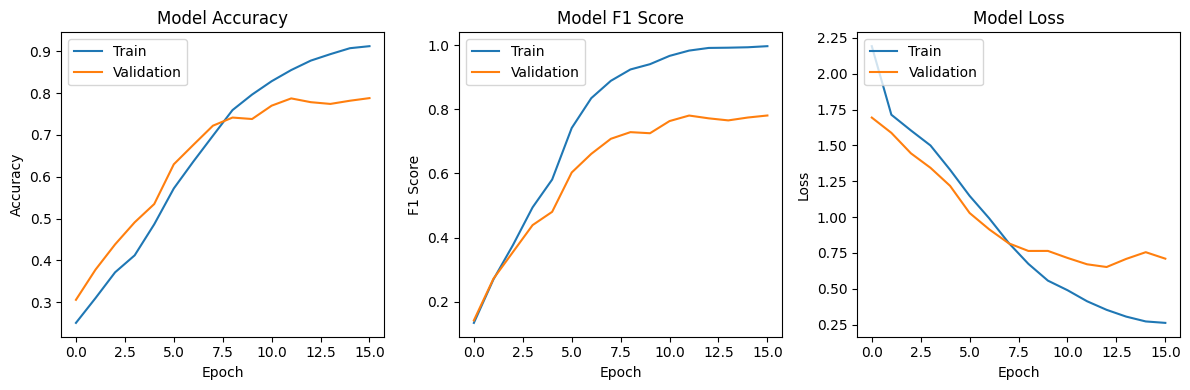

In [35]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot F1 score
plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 3, 3) # Added a new subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()

In [36]:
loss, accuracy = speech_model.evaluate(
    [combined_1d_speech_test, combined_2d_speech_test_reshaped],
    speech_labels_test_encoded,
    verbose=0
)

# Predict on the test set to calculate F1 score
y_pred_probs = speech_model.predict([combined_1d_speech_test, combined_2d_speech_test_reshaped])
y_pred = np.argmax(y_pred_probs, axis=1)
test_f1_score = f1_score(speech_labels_test_encoded, y_pred, average='macro')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Loss: 0.6520
Test Accuracy: 0.7785
Test F1 Score: 0.7717


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


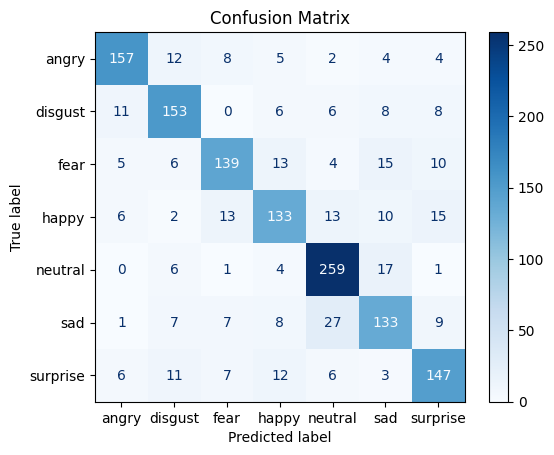

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred_probs = speech_model.predict([combined_1d_speech_test, combined_2d_speech_test_reshaped])
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(speech_labels_test_encoded, y_pred)

# Get the class labels (assuming they are 0 to num_classes-1)
class_labels = speech_label_encoder.classes_

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Save the entire model
speech_model.save('/kaggle/working/models/speech/speech_rec_model.h5')
print("Model saved successfully!")

Model saved successfully!


### 2.2 Song Emotion Recogniser

In [18]:
song_zcr_stats = np.load("/kaggle/working/feats/song/song_zcr_stats.npy")
song_rmse_stats = np.load("/kaggle/working/feats/song/song_rmse_stats.npy")
song_mfcc_2d_padded = np.load("/kaggle/working/feats/song/song_mfcc_2d_padded.npy")
song_chroma_2d_padded = np.load("/kaggle/working/feats/song/song_chroma_2d_padded.npy")
song_labels = np.load("/kaggle/working/feats/song/song_labels.npy")

print("Shape of song_zcr_stats:", song_zcr_stats.shape)
print("Shape of song_rmse_stats:", song_rmse_stats.shape)
print("Shape of song_mfcc_2d_padded:", song_mfcc_2d_padded.shape)
print("Shape of song_chroma_2d_padded:", song_chroma_2d_padded.shape)
print("Shape of song_labels:", song_labels.shape)

Shape of song_zcr_stats: (5060, 2)
Shape of song_rmse_stats: (5060, 2)
Shape of song_mfcc_2d_padded: (5060, 216, 20)
Shape of song_chroma_2d_padded: (5060, 216, 12)
Shape of song_labels: (5060,)


In [19]:
print("Song features:")
print("ZCR Stats Description:")
print(np.mean(song_zcr_stats, axis=0))
print(np.std(song_zcr_stats, axis=0))
print(np.min(song_zcr_stats, axis=0))
print(np.max(song_zcr_stats, axis=0))
print("\nRMSE Stats Description:")
print(np.mean(song_rmse_stats, axis=0))
print(np.std(song_rmse_stats, axis=0))
print(np.min(song_rmse_stats, axis=0))
print(np.max(song_rmse_stats, axis=0))
print("\nMFCC 2D Padded Description:")
print(np.mean(song_mfcc_2d_padded))
print(np.std(song_mfcc_2d_padded))
print(np.min(song_mfcc_2d_padded))
print(np.max(song_mfcc_2d_padded))
print("\nChroma 2D Padded Description:")
print(np.mean(song_chroma_2d_padded))
print(np.std(song_chroma_2d_padded))
print(np.min(song_chroma_2d_padded))
print(np.max(song_chroma_2d_padded))

Song features:
ZCR Stats Description:
[0.1650417  0.14023045]
[0.04371956 0.04179223]
[0.05619527 0.0321396 ]
[0.35534668 0.28428357]

RMSE Stats Description:
[0.02093212 0.01513319]
[0.01618362 0.01260661]
[0.00159147 0.0011384 ]
[0.11032509 0.09224775]

MFCC 2D Padded Description:
-12.524517809889405
73.20957472876326
-954.2120361328125
214.23291015625

Chroma 2D Padded Description:
0.16101347998265975
0.28782527405187874
0.0
1.0


In [84]:
# # Initialize StandardScaler
# scaler_1d_song = StandardScaler()
# scaler_2d_song = StandardScaler()

# # Reshape 2D song data for scaling (flatten the last two dimensions temporarily)
# song_mfcc_2d_reshaped_for_scaling = song_mfcc_2d_padded.reshape(song_mfcc_2d_padded.shape[0], -1)
# song_chroma_2d_reshaped_for_scaling = song_chroma_2d_padded.reshape(song_chroma_2d_padded.shape[0], -1)


# # Fit and transform 1D song features
# song_zcr_stats_scaled = scaler_1d_song.fit_transform(song_zcr_stats)
# song_rmse_stats_scaled = scaler_1d_song.fit_transform(song_rmse_stats)

# # Fit and transform 2D song features
# song_mfcc_2d_scaled_reshaped = scaler_2d_song.fit_transform(song_mfcc_2d_reshaped_for_scaling)
# song_chroma_2d_scaled_reshaped = scaler_2d_song.fit_transform(song_chroma_2d_reshaped_for_scaling)

# # Reshape 2D scaled song data back to original 3D shape
# song_mfcc_2d_scaled = song_mfcc_2d_scaled_reshaped.reshape(song_mfcc_2d_padded.shape)
# song_chroma_2d_scaled = song_chroma_2d_scaled_reshaped.reshape(song_chroma_2d_padded.shape)

# print("Shape of scaled song_zcr_stats:", song_zcr_stats_scaled.shape)
# print("Shape of scaled song_rmse_stats:", song_rmse_stats_scaled.shape)
# print("Shape of scaled song_mfcc_2d_padded:", song_mfcc_2d_scaled.shape)
# print("Shape of scaled song_chroma_2d_padded:", song_chroma_2d_scaled.shape)

In [40]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler_1d_song = StandardScaler()
scaler_2d_song = StandardScaler()

# Fit and transform 1D song features
combined_1d_song_features = np.concatenate((song_zcr_stats, song_rmse_stats), axis=1)
combined_1d_song_features_scaled = scaler_1d_song.fit_transform(combined_1d_song_features)


# Reshape 2D song data for scaling (flatten the last two dimensions temporarily)
song_mfcc_2d_reshaped_for_scaling = song_mfcc_2d_padded.reshape(song_mfcc_2d_padded.shape[0], -1)
song_chroma_2d_reshaped_for_scaling = song_chroma_2d_padded.reshape(song_chroma_2d_padded.shape[0], -1)

# Concatenate flattened 2D features before fitting and transforming with scaler_2d_song
combined_2d_song_features_reshaped_for_scaling = np.concatenate((song_mfcc_2d_reshaped_for_scaling, song_chroma_2d_reshaped_for_scaling), axis=1)
combined_2d_song_features_scaled_reshaped = scaler_2d_song.fit_transform(combined_2d_song_features_reshaped_for_scaling)

# Reshape 2D scaled song data back to original 3D shape
original_shape_2d_song = (song_mfcc_2d_padded.shape[0], song_mfcc_2d_padded.shape[1], song_mfcc_2d_padded.shape[2] + song_chroma_2d_padded.shape[2])
combined_2d_song_features_scaled = combined_2d_song_features_scaled_reshaped.reshape(original_shape_2d_song)


print("Shape of scaled combined_1d_song_features:", combined_1d_song_features_scaled.shape)
print("Shape of scaled combined_2d_song_features:", combined_2d_song_features_scaled.shape)

Shape of scaled combined_1d_song_features: (5060, 4)
Shape of scaled combined_2d_song_features: (5060, 216, 32)


In [41]:
print("Scaled Song Features:")
print("ZCR-RMSE Stats Description:")
print(np.mean(combined_1d_song_features_scaled, axis=0))
print(np.std(combined_1d_song_features_scaled, axis=0))
print(np.min(combined_1d_song_features_scaled, axis=0))
print(np.max(combined_1d_song_features_scaled, axis=0))
print("\nMFCC-Chroma:")
print(np.mean(combined_2d_song_features_scaled))
print(np.std(combined_2d_song_features_scaled))
print(np.min(combined_2d_song_features_scaled))
print(np.max(combined_2d_song_features_scaled))

Scaled Song Features:
ZCR-RMSE Stats Description:
[-1.06122840e-15 -6.13516155e-17  1.11362391e-16 -1.10835803e-16]
[1. 1. 1. 1.]
[-2.48965062 -2.58638659 -1.19507578 -1.11011476]
[4.35285685 3.44688798 5.52367218 6.11699518]

MFCC-Chroma:
5.200869095008785e-19
0.9999999999999999
-70.94058637929182
71.1228700812255


In [42]:
(combined_1d_song_train, combined_1d_song_test,
 combined_2d_song_train, combined_2d_song_test,
 song_labels_train, song_labels_test) = train_test_split(combined_1d_song_features_scaled, # Use the combined and scaled 1D features
                                                        combined_2d_song_features_scaled, # Use the combined and scaled 2D features
                                                        song_labels,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=song_labels)

# Reshape 2D data to include a channel dimension
combined_2d_song_train_reshaped = np.expand_dims(combined_2d_song_train, axis=-1)
combined_2d_song_test_reshaped = np.expand_dims(combined_2d_song_test, axis=-1)

print("Shape of combined_1d_song_train:", combined_1d_song_train.shape)
print("Shape of combined_1d_song_test:", combined_1d_song_test.shape)
print("Shape of combined_2d_song_train_reshaped:", combined_2d_song_train_reshaped.shape)
print("Shape of combined_2d_song_test_reshaped:", combined_2d_song_test_reshaped.shape)
print("Shape of song_labels_train:", song_labels_train.shape)
print("Shape of song_labels_test:", song_labels_test.shape)

Shape of combined_1d_song_train: (4048, 4)
Shape of combined_1d_song_test: (1012, 4)
Shape of combined_2d_song_train_reshaped: (4048, 216, 32, 1)
Shape of combined_2d_song_test_reshaped: (1012, 216, 32, 1)
Shape of song_labels_train: (4048,)
Shape of song_labels_test: (1012,)


In [46]:
# Define input shapes for song data
input_shape_1d_song = (combined_1d_song_train.shape[1],)
input_shape_2d_song = combined_2d_song_train_reshaped.shape[1:]

# 1D CNN branch for song data
input_1d_song = Input(shape=input_shape_1d_song, name='input_1d_song')
x_song = Dense(64, activation='relu')(input_1d_song)
x_song = Dropout(0.38)(x_song)
x_song = Dense(32, activation='relu')(x_song)
x_song = Dropout(0.38)(x_song)
flat_1d_song = Flatten()(x_song)

# 2D CNN branch for song data
input_2d_song = Input(shape=input_shape_2d_song, name='input_2d_song')
y_song = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_2d_song)
y_song = MaxPooling2D(pool_size=(2, 2))(y_song)
y_song = Dropout(0.265)(y_song)
y_song = Conv2D(64, kernel_size=(3, 3), activation='relu')(y_song)
y_song = MaxPooling2D(pool_size=(2, 2))(y_song)
y_song = Dropout(0.265)(y_song)
flat_2d_song = Flatten()(y_song)

# Concatenate branches for song data
combined_song = concatenate([flat_1d_song, flat_2d_song])

# Fully connected layers for song data
z_song = Dense(128, activation='relu')(combined_song)
z_song = Dropout(0.38)(z_song)
z_song = Dense(64, activation='relu')(z_song)
z_song = Dropout(0.38)(z_song)

# Output layer for song data (using the number of unique song labels)
output_layer_song = Dense(len(np.unique(song_labels)), activation='softmax')(z_song)

# Create the model for song data
song_model = Model(inputs=[input_1d_song, input_2d_song], outputs=output_layer_song)

In [47]:
# Compile the song model
song_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(),
                   metrics=['accuracy'])

song_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2d_song       │ (None, 216, 32,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 214, 30,   │        320 │ input_2d_song[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1d_song       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 107, 15,   │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │        320 │ input_1d_song[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 107, 15,   │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 64)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 105, 13,   │     18,496 │ dropout_44[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 32)        │      2,080 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 52, 6, 64) │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 32)        │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 52, 6, 64) │          0 │ max_pooling2d_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 32)        │          0 │ dropout_43[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 19968)     │          0 │ dropout_45[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 20000)     │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │  2,560,128 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 128)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      8,256 │ dropout_46[0][0]

 Total params: 2,589,925 (9.88 MB)

 Trainable params: 2,589,925 (9.88 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Initialize LabelEncoder
label_encoder_song = LabelEncoder()

# Fit and transform the training and testing labels
song_labels_train_encoded = label_encoder_song.fit_transform(song_labels_train)
song_labels_test_encoded = label_encoder_song.transform(song_labels_test)

# Instantiate the custom F1ScoreCallback
f1_callback_song = F1ScoreCallback(train_data=([combined_1d_song_train, combined_2d_song_train_reshaped], song_labels_train_encoded),
                                   validation_data=([combined_1d_song_test, combined_2d_song_test_reshaped], song_labels_test_encoded))

early_stopping_song = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the song model
song_history = song_model.fit(
    [combined_1d_song_train, combined_2d_song_train_reshaped],
    song_labels_train_encoded,
    epochs=25,
    batch_size=32,
    validation_data=([combined_1d_song_test, combined_2d_song_test_reshaped], song_labels_test_encoded),
    callbacks=[f1_callback_song, early_stopping_song]
)

Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step    accuracy: 0.2830
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1: Train F1 = 0.2676, Val F1 = 0.2822
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.2833 - loss: 1.7012 - val_accuracy: 0.4377 - val_loss: 1.3426 - f1_score: 0.2676 - val_f1_score: 0.2822
Epoch 2/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4080 - l
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 2: Train F1 = 0.3527, Val F1 = 0.3354
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4080 - loss: 1.3530 - val_accuracy: 0.4575 - val_loss: 1.2261 - f1_score: 0.3527 - val_f1_score: 0.3354
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4322 - l
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 3: Train F1 = 0.4200, Val F1 = 0.4076
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4328 - loss: 1.2885 - val_accuracy: 0.5049 - val_loss: 1.1369 - f1_score: 0.4200 - val_f1_score: 0.4076
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [49]:
song_loss, song_accuracy = song_model.evaluate(
    [combined_1d_song_test, combined_2d_song_test_reshaped],
    song_labels_test_encoded,
    verbose=0
)

song_y_pred_probs = song_model.predict([combined_1d_song_test, combined_2d_song_test_reshaped])
song_y_pred = np.argmax(song_y_pred_probs, axis=1)
song_test_f1_score = f1_score(song_labels_test_encoded, song_y_pred, average='macro')

print(f"Song Test Loss: {song_loss:.4f}")
print(f"Song Test Accuracy: {song_accuracy:.4f}")
print(f"Song Test F1 Score: {song_test_f1_score:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Song Test Loss: 0.4357
Song Test Accuracy: 0.8597
Song Test F1 Score: 0.8547


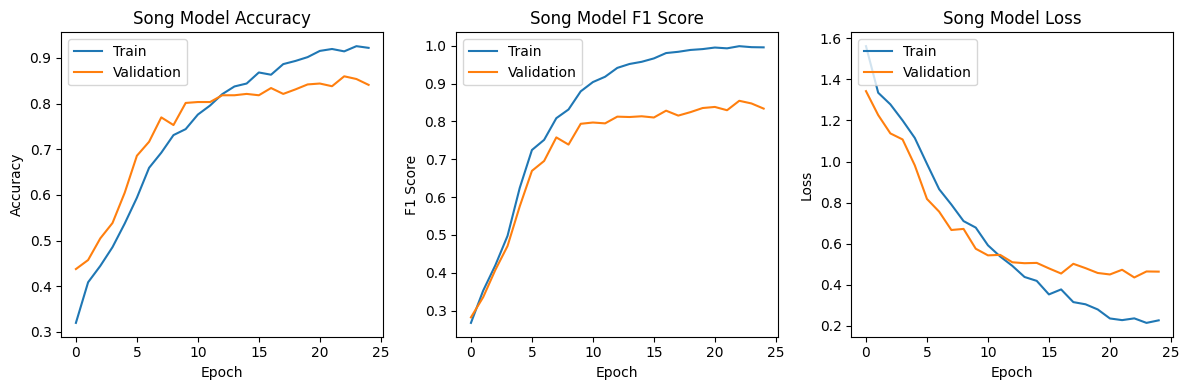

In [50]:
# Plot accuracy and loss for song model
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(song_history.history['accuracy'])
plt.plot(song_history.history['val_accuracy'])
plt.title('Song Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot F1 score
plt.subplot(1, 3, 2)
plt.plot(song_history.history['f1_score'])
plt.plot(song_history.history['val_f1_score'])
plt.title('Song Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 3, 3)
plt.plot(song_history.history['loss'])
plt.plot(song_history.history['val_loss'])
plt.title('Song Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


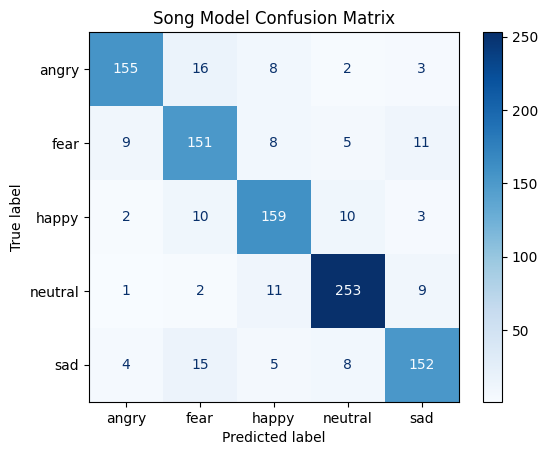

In [51]:
# Get predictions on the song test set
song_y_pred_probs = song_model.predict([combined_1d_song_test, combined_2d_song_test_reshaped])
song_y_pred = np.argmax(song_y_pred_probs, axis=1)

# Generate the confusion matrix for song data
song_cm = confusion_matrix(song_labels_test_encoded, song_y_pred)

# Get the class labels for song data
song_class_labels = label_encoder_song.classes_

# Display the confusion matrix for song data
song_disp = ConfusionMatrixDisplay(confusion_matrix=song_cm, display_labels=song_class_labels)
song_disp.plot(cmap=plt.cm.Blues)
plt.title('Song Model Confusion Matrix')
plt.show()

In [52]:
# Save the song model
song_model.save('/kaggle/working/models/song/song_rec_model.h5')
print("Song model saved successfully!")

Song model saved successfully!


In [53]:
import pickle

# Save speech dataset objects
with open('/kaggle/working/models/speech/pkl/speech_label_encoder.pkl', 'wb') as f:
    pickle.dump(speech_label_encoder, f)

with open('/kaggle/working/models/speech/pkl/speech_scaler_1d.pkl', 'wb') as f:
    pickle.dump(scaler_1d, f)

with open('/kaggle/working/models/speech/pkl/speech_scaler_2d.pkl', 'wb') as f:
    pickle.dump(scaler_2d, f)

# Save song dataset objects
with open('/kaggle/working/models/song/pkl/label_encoder_song.pkl', 'wb') as f:
    pickle.dump(label_encoder_song, f)

with open('/kaggle/working/models/song/pkl/scaler_1d_song.pkl', 'wb') as f:
    pickle.dump(scaler_1d_song, f)

with open('/kaggle/working/models/song/pkl/scaler_2d_song.pkl', 'wb') as f:
    pickle.dump(scaler_2d_song, f)

print("Encoder and scaler objects saved successfully!")

Encoder and scaler objects saved successfully!


## 3. Prediction

In [54]:
ip_audio_1 = "/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-01-01-02-02-03.wav"
ip_audio_2 = "/kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-05-02-02-02-09.wav"
ip_audio_3 = "/kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-08-02-02-01-19.wav"

In [55]:
with open('/kaggle/working/max_len/max_chroma_len_song.txt', 'r') as f:
    max_chroma_len_song = int(f.read())
with open('/kaggle/working/max_len/max_mfcc_len_song.txt', 'r') as f:
    max_mfcc_len_song = int(f.read())
with open('/kaggle/working/max_len/max_mfcc_len_speech.txt', 'r') as f:
    max_mfcc_len_speech = int(f.read())
with open('/kaggle/working/max_len/max_spectrogram_len_speech.txt', 'r') as f:
    max_spectrogram_len_speech = int(f.read())

print(f"max_chroma_len_song = {max_chroma_len_song}")
print(f"max_mfcc_len_song = {max_mfcc_len_song}")
print(f"max_mfcc_len_speech = {max_mfcc_len_speech}")
print(f"max_spectrogram_len_speech = {max_spectrogram_len_speech}")

max_chroma_len_song = 216
max_mfcc_len_song = 216
max_mfcc_len_speech = 215
max_spectrogram_len_speech = 215


In [56]:
import librosa

In [57]:
def zcr_feature(data,frame_length,hop_length):
    zcr_result=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr_result) # Returns 1D array

def rmse_feature(data, frame_length=2048, hop_length=512):
    rmse_result = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse_result) # Returns 1D array

def mfcc_feature(data, sr, frame_length=2048, hop_length=512):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return mfcc_result.T # Returns 2D array (time x n_mfcc)

def extract_spectrogram_features(data, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T # Returns 2D array (time x n_mels)

def extract_chroma_features(data, sr, frame_length=2048, hop_length=512):
    chromagram = librosa.feature.chroma_stft(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return chromagram.T # Returns 2D array (time x n_chroma)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512, dataset_type='speech'):
    zcr_features_val = zcr_feature(data,frame_length,hop_length)
    rmse_features_val = rmse_feature(data,frame_length,hop_length)
    mfcc_features_val = mfcc_feature(data,sr,frame_length,hop_length)

    if dataset_type == 'speech':
        additional_features_val = extract_spectrogram_features(data, sr)
    elif dataset_type == 'song':
        additional_features_val = extract_chroma_features(data, sr, frame_length, hop_length)
    else:
        raise ValueError("dataset_type must be 'speech' or 'song'")

    return zcr_features_val, rmse_features_val, mfcc_features_val, additional_features_val

In [58]:
def pad_or_truncate(arr, max_len):
    """Pads or truncates a 2D array to a specified length."""
    if arr.shape[0] > max_len:
        return arr[:max_len, :]
    elif arr.shape[0] < max_len:
        padding = np.zeros((max_len - arr.shape[0], arr.shape[1]))
        return np.vstack((arr, padding))
    return arr

In [64]:
def preprocess_ip_audio(file_path, dataset_type, scaler_1d, scaler_2d, max_mfcc_len, max_additional_len):
    data, sr = librosa.load(file_path, duration=2.5, offset=0.6)
    zcr_val, rmse_val, mfcc_val, additional_val = extract_features(data, sr, dataset_type=dataset_type)

    mfcc_padded = pad_or_truncate(mfcc_val, max_mfcc_len)
    additional_padded = pad_or_truncate(additional_val, max_additional_len)

    # Calculate mean and std for ZCR and RMSE
    zcr_stats = np.array([np.mean(zcr_val), np.std(zcr_val)]).reshape(1, -1)
    rmse_stats = np.array([np.mean(rmse_val), np.std(rmse_val)]).reshape(1, -1)

    # Concatenate 1D features before scaling
    combined_1d_features = np.concatenate((zcr_stats, rmse_stats), axis=1)

    # Scale combined 1D features
    combined_1d_features_scaled = scaler_1d.transform(combined_1d_features)

    # Flatten 2D features for scaling
    mfcc_padded_reshaped_for_scaling = mfcc_padded.reshape(1, -1)
    additional_padded_reshaped_for_scaling = additional_padded.reshape(1, -1) # Renamed spectro_padded_reshaped_for_scaling to additional_padded_reshaped_for_scaling

    # Concatenate flattened 2D features before scaling
    combined_2d_features_reshaped_for_scaling = np.concatenate((mfcc_padded_reshaped_for_scaling, additional_padded_reshaped_for_scaling), axis=1) # Updated concatenation

    # Scale the combined flattened 2D features
    combined_2d_features_scaled_reshaped = scaler_2d.transform(combined_2d_features_reshaped_for_scaling)

    # Reshape the scaled 2D features back to their original 3D shape
    # The target shape should be (number_of_samples, max_time_steps, combined_feature_dimension)
    # For a single unseen sample, number_of_samples is 1
    original_shape_2d = (1, mfcc_padded.shape[0], mfcc_padded.shape[1] + additional_padded.shape[1]) # Updated dimension calculation
    combined_2d_features_scaled = combined_2d_features_scaled_reshaped.reshape(original_shape_2d)


    # Reshape combined 2D data to include a channel dimension for CNN input
    combined_2d_features_scaled_reshaped_cnn = np.expand_dims(combined_2d_features_scaled, axis=-1)

    return combined_1d_features_scaled, combined_2d_features_scaled_reshaped_cnn

In [111]:
def predict_speech_emotion(file_path, dataset_type, scaler_1d, scaler_2d, max_mfcc_len, max_additional_len, model, label_encoder):
    # Preprocess the unseen audio file
    preprocessed_1d, preprocessed_2d = preprocess_ip_audio(
        file_path,
        dataset_type,
        scaler_1d,
        scaler_2d,
        max_mfcc_len,
        max_additional_len
    )

    # Make a prediction using the trained model
    prediction = model.predict([preprocessed_1d, preprocessed_2d])

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the predicted emotion label with the highest confidence
    predicted_emotion_max_score = label_encoder.inverse_transform([predicted_class_index])[0]

    # Get all class labels
    all_labels = label_encoder.classes_

    # Combine labels and confidence scores into a dictionary
    emotion_confidence_scores_dict = {label: float(score) for label, score in zip(all_labels, prediction[0])}

    # Return only the predicted emotion and the confidence scores dictionary
    return predicted_emotion_max_score, emotion_confidence_scores_dict

In [117]:
def predict_song_emotion(file_path, dataset_type, scaler_1d_song, scaler_2d_song, max_mfcc_len_song, max_chroma_len_song, song_model, label_encoder_song):
    # Preprocess the unseen audio file
    preprocessed_1d, preprocessed_2d = preprocess_ip_audio(
        file_path,
        dataset_type,
        scaler_1d_song,
        scaler_2d_song,
        max_mfcc_len_song,
        max_chroma_len_song
    )

    # Make a prediction using the trained song model
    prediction = song_model.predict([preprocessed_1d, preprocessed_2d])

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the predicted emotion label with the highest confidence
    predicted_emotion_max_score = label_encoder_song.inverse_transform([predicted_class_index])[0]

    # Get all class labels
    all_labels = label_encoder_song.classes_

    # Combine labels and confidence scores into a dictionary
    emotion_confidence_scores_dict = {label: float(score) for label, score in zip(all_labels, prediction[0])}

    # Return only the predicted emotion and the confidence scores dictionary
    return predicted_emotion_max_score, emotion_confidence_scores_dict

In [122]:
prediction, scores = predict_speech_emotion(ip_audio_3, 'speech', scaler_1d, scaler_2d, max_mfcc_len_speech, max_spectrogram_len_speech, speech_model, speech_label_encoder)
print(prediction)
print(scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
surprise
{'angry': 0.003314885077998042, 'disgust': 0.0004986226558685303, 'fear': 0.006248766556382179, 'happy': 0.008210714906454086, 'neutral': 0.0001815501309465617, 'sad': 0.0004806862270925194, 'surprise': 0.9810647368431091}


In [97]:
ip_audio_4 = '/kaggle/input/ravdess-emotional-song-audio/Actor_04/03-02-03-02-01-02-04.wav'
ip_audio_5 = '/kaggle/input/ravdess-emotional-song-audio/Actor_07/03-02-06-02-01-01-07.wav'
ip_audio_6 = '/kaggle/input/ravdess-emotional-song-audio/Actor_14/03-02-04-02-02-02-14.wav'

In [118]:
p, s = predict_song_emotion(ip_audio_6, 'song', scaler_1d_song, scaler_2d_song, max_mfcc_len_song, max_chroma_len_song, song_model, label_encoder_song)
print(p)
print(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
sad
{'angry': 3.14974931825418e-05, 'fear': 0.011332672089338303, 'happy': 5.241330654826015e-05, 'neutral': 0.03324412181973457, 'sad': 0.9553393125534058}


In [101]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.37.2
    Uninstalling pydantic_core-2.37.2:
      Successfully uninstalled pydantic_core-2.37.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.0a1
    Uninstalling pydantic-2.12.0a1:
      Successfully uninstalled pydantic-2.12.0a1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [126]:
def predict_emotion(audio_file_path, dataset_type):
    """
    Predicts the emotion of an audio file based on its dataset type (speech or song).

    Args:
        audio_file_path (str): The path to the audio file.
        dataset_type (str): The type of dataset ('speech' or 'song').

    Returns:
        tuple: A tuple containing the predicted emotion label (str) and a dictionary of
               emotion confidence scores (dict).
    """
    if dataset_type == 'speech':
        predicted_emotion_max_score, emotion_confidence_scores_dict = predict_speech_emotion(
            audio_file_path,
            dataset_type,
            scaler_1d,
            scaler_2d,
            max_mfcc_len_speech,
            max_spectrogram_len_speech,
            speech_model,
            speech_label_encoder
        )
    elif dataset_type == 'song':
        predicted_emotion_max_score, emotion_confidence_scores_dict = predict_song_emotion(
            audio_file_path,
            dataset_type,
            scaler_1d_song,
            scaler_2d_song,
            max_mfcc_len_song,
            max_chroma_len_song,
            song_model,
            label_encoder_song
        )
    else:
        raise ValueError("dataset_type must be 'speech' or 'song'")

    return predicted_emotion_max_score, emotion_confidence_scores_dict

In [127]:
import gradio as gr

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_emotion,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Radio(["speech", "song"], label="Dataset Type")
    ],
    outputs=[
        gr.Textbox(label="Predicted Emotion"),
        gr.Label(label="Confidence Scores")
    ],
    title="Emotion Recognition from Audio",
    description="Upload an audio file (speech or song) to predict its emotion."
)

In [128]:
iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://580041b6abc7b866e5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://580041b6abc7b866e5.gradio.live
